In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from typing import List, Optional, Tuple, Union

from pandas.core.frame import DataFrame
from pandas.core.series import Series

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from rich.table import Table

In [102]:
path = '/Users/f.b/Desktop/Data_Science/Clock_industry/lib/data/propre.csv'
df = pd.read_csv(path)
df = df.iloc[:, 1:]
df = df.drop(columns=['annee_prod', 'pays', 'etencheite'])

In [103]:
def get_object_columns(df):
    """
    Renvoie une liste des colonnes de type 'object' dans un DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame à analyser.

    Returns:
        List[str]: Liste des noms des colonnes de type 'object'.
    """
    return df.select_dtypes(include=['object']).columns.tolist()

In [104]:
def group_rare_categories(df, columns, threshold=0.05):
    """
    Regroupe les catégories rares dans une valeur unique "Autres".

    Args:
        df (pd.DataFrame): Le DataFrame à traiter.
        columns (list): Les colonnes catégoriques à traiter.
        threshold (float): Fréquence minimale pour conserver une catégorie.

    Returns:
        pd.DataFrame: DataFrame avec les catégories rares regroupées.
    """
    for col in columns:
        frequency = df[col].value_counts(normalize=True)
        rare_categories = frequency[frequency < threshold].index
        df[col] = df[col].apply(lambda x: "Autres" if x in rare_categories else x)
    return df

In [105]:
object_columns = get_object_columns(df)
df = group_rare_categories(df, object_columns, threshold=0.05)

In [106]:
df['prix_log'] = np.log(df['prix'])
df = df.drop(['prix'], axis = 1)

In [107]:
df = df[(df['prix_log'].between(7, 11)) | (df['prix_log'].isna())]

In [108]:
df = df[(df['reserve_de_marche'].between(24, 72)) | (df['reserve_de_marche'].isna())]

In [109]:
df = df[(df['diametre'].between(30, 50)) | (df['diametre'].isna())]

In [110]:
#df = df[(df['etencheite'].between(10, 50)) | (df['etencheite'].isna())]

In [111]:
#sns.boxplot(x=df['comptage_fonctions'])

In [112]:
df.isnull().sum()

marque                   0
modele                   0
mouvement               19
matiere_boitier        217
matiere_bracelet      1928
etat                     0
sexe                   245
reserve_de_marche     1781
diametre               282
matiere_lunette        942
matiere_verre          703
boucle                 601
matiere_boucle         586
comptage_fonctions       0
prix_log               961
dtype: int64

In [113]:
df.shape

(20976, 15)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


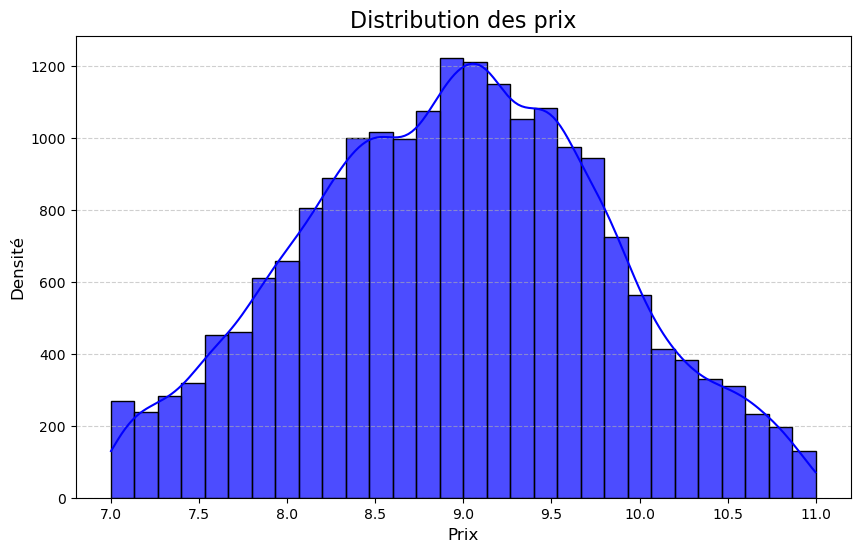

In [114]:
# Représentation de la distribution des prix
plt.figure(figsize=(10, 6))
sns.histplot(
    df['prix_log'], 
    bins=30, # Ajustez le nombre de bins selon la précision souhaitée
    kde=True, # Ajout d'une courbe de densité
    color="blue",
    alpha=0.7
)
plt.title("Distribution des prix", fontsize=16)
plt.xlabel("Prix", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [115]:
# Remplacer les valeurs manquantes par la médiane pour toutes les colonnes numériques
df.fillna(df.select_dtypes(include='float64').median(), inplace=True)

# Remplacer les valeurs manquantes par la modalité la plus fréquente pour toutes les colonnes catégorielles
df.fillna(df.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [116]:
df = pd.get_dummies(
    df,
    dummy_na=False, 
    drop_first=True,
    dtype=float
    )

In [117]:
X = df.drop(['prix_log'], axis=1)  # Remplacez 'target_column' par le nom de votre colonne cible
y = df['prix_log']  # Votre colonne cible

# Découpage en données d'apprentissage (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
print(f"{X_train.shape[0]:,} exemples d'entrainement pour {X_train.shape[1]} features.")
print(f"{X_test.shape[0]:,} exemples test.")

16,780 exemples d'entrainement pour 32 features.
4,196 exemples test.


In [119]:
features = list(X_train.columns)

In [120]:
from typing import (
    Optional, 
    Dict, 
    List,
    Union
)

def compute_mutual_info(X: np.ndarray, y: np.ndarray, feature_names: List, n_neighbors: int=10) -> pd.Series: 
    """Description. Compute mutual information for each feature.
    
    Args:
        X (np.ndarray): Feature vector.
        y (np.ndarray): Target vector.
        feature_names (List): List of feature names.
        n_neighbors (int): Number of neighbors to use for MI estimation.
        
    Returns:
        pd.Series: Mutual information for each feature sorted in descending order."""

    mi = mutual_info_regression(
        X, 
        y, 
        discrete_features="auto", 
        n_neighbors=n_neighbors, 
        copy=True) 

    mi = pd.Series(mi, index=feature_names).sort_values(ascending=False)
    return mi

def compute_rf_importances(
        X: np.ndarray, 
        y: np.ndarray, 
        feature_names: List, 
        rf: Optional[RandomForestRegressor]=None, 
        kwargs: Optional[Dict]=None
    ) -> pd.Series: 
    """Description. Compute mean decrease Ginin for each feature from random forest.
    
    Args:
        X (np.ndarray): Feature vector.
        y (np.ndarray): Target vector.
        feature_names (List): List of feature names.
        kwargs (Optional[Dict]): arguments to pass to RandomForestRegressor.
        
    Returns:
        pd.Series: Random forest importances for each feature sorted in descending order."""

    if rf == None: 

        if kwargs == None:
            rf = RandomForestRegressor()
        else:
            rf = RandomForestRegressor(**kwargs)
        rf.fit(X, y)
        print("RandomForestRegressor fitted.")

        mape = 100 * mean_absolute_percentage_error(y, rf.predict(X))
        print(f"Train MAPE: {round(mape, 2)}%")

    importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
    return importances

def select_important_features(importances: pd.Series, threshold: Union[str, float] = "mean") -> List[str]:
    """
    Sélectionne les features dont l'importance est supérieure à un seuil donné.

    Args:
        importances (pd.Series): Série contenant les importances des features.
        threshold (Union[str, float]): Seuil pour la sélection des features.
                                       Peut être 'mean', '25%', '50%', '75%', '90%', '95%', '99%', ou un float.

    Returns:
        List[str]: Liste des features sélectionnées.
    """
    # Vérifier que importances est bien une pd.Series
    if not isinstance(importances, pd.Series):
        raise TypeError("Les importances doivent être une pd.Series.")
    
    # Calcul du seuil basé sur les différentes options
    if threshold == "mean":
        threshold = importances.mean()
    elif threshold in ["25%", "50%", "75%", "90%", "95%", "90%", "99%"]:
        quantile = float(threshold.strip('%')) / 100
        threshold = importances.quantile(quantile)
    elif isinstance(threshold, float):
        # Si le seuil est un float explicite
        pass
    else:
        raise ValueError(f"{threshold} n'est pas une méthode de seuil valide.")
    
    # Sélectionner les features avec une importance supérieure au seuil
    selected_features = importances[importances > threshold].index.tolist()
    
    return selected_features

In [121]:
mi_threshold = "50%"
mdg_threshold = "75%"

mi_values = compute_mutual_info(X_train, y_train, features, n_neighbors=5)
mdg_values = compute_rf_importances(X_train, y_train, features)

important_features_mi = select_important_features(mi_values, threshold=mi_threshold)
important_features_mdg = select_important_features(mdg_values, threshold=mdg_threshold)


RandomForestRegressor fitted.
Train MAPE: 2.0%


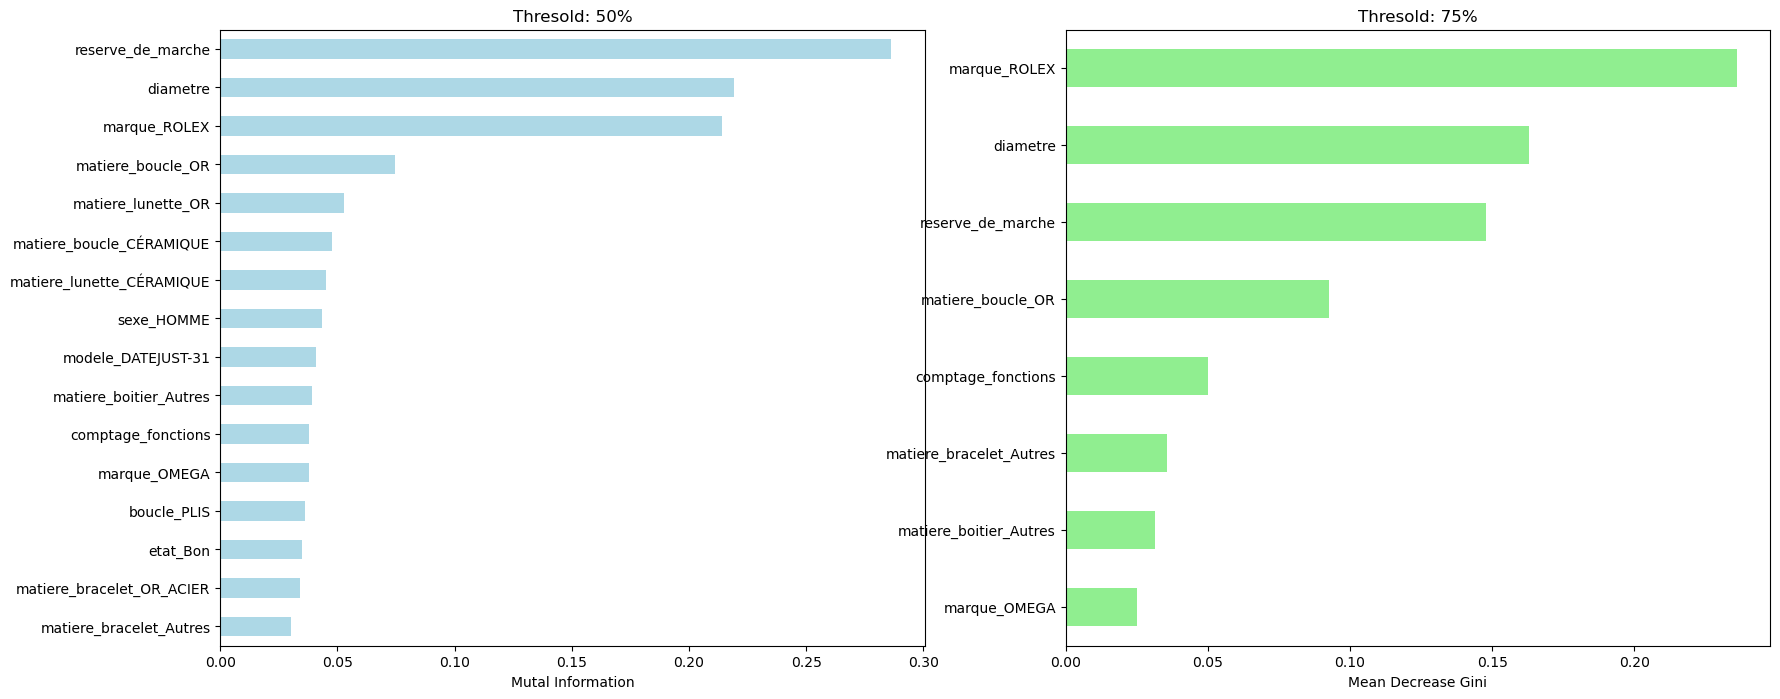

In [122]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))

mi_values[important_features_mi]\
    .sort_values()\
    .plot.barh(ax=axes[0], color="lightblue")

axes[0].set_xlabel("Mutal Information")
axes[0].set_title(f"Thresold: {mi_threshold}")

mdg_values[important_features_mdg]\
    .sort_values()\
    .plot.barh(ax=axes[1], color="lightgreen")

axes[1].set_xlabel("Mean Decrease Gini")
axes[1].set_title(f"Thresold: {mdg_threshold}"); 


In [123]:
features_selected = list(set(important_features_mdg + important_features_mi))
features_selected

['reserve_de_marche',
 'marque_OMEGA',
 'diametre',
 'matiere_boitier_Autres',
 'comptage_fonctions',
 'matiere_lunette_OR',
 'matiere_lunette_CÉRAMIQUE',
 'modele_DATEJUST-31',
 'marque_ROLEX',
 'sexe_HOMME',
 'boucle_PLIS',
 'matiere_bracelet_OR_ACIER',
 'matiere_boucle_OR',
 'etat_Bon',
 'matiere_boucle_CÉRAMIQUE',
 'matiere_bracelet_Autres']

In [124]:
X_tr_reduced = X_train[features_selected]
X_te_reduced = X_test[features_selected]

In [125]:
def is_dummy(x: Union[Series, np.ndarray]) -> bool:
    """Description. Checks if a numpy array is a dummy variable."""

    if isinstance(x, Series):
        x = x.values

    x = x.astype(float)
    x = x[~np.isnan(x)]

    return np.all(np.isin(x, [0., 1.]))

In [126]:
def is_numeric(x: Series) -> bool:
    """Description. Checks if a numpy array is numeric."""

    if x.dtype == "int64" and not is_dummy(x):  
        return True
    
    return False

In [127]:
numeric_features = [var for var in features_selected if is_numeric(df[var])]
category_features = [var for var in features_selected if var not in numeric_features] 

print(f"Numeric features: {len(numeric_features)}")
print(f"Dummy features: {len(category_features)}")

Numeric features: 1
Dummy features: 15


In [128]:
cor_method = "spearman"

cor = df[numeric_features + ['prix_log']]\
    .corr(method=cor_method)["prix_log"]\
    .drop("prix_log")\
    .sort_values(ascending=False)\
    .reset_index()\
    .rename(columns={"index": "feature", "prix_log": "spearman"})

cor

,feature,spearman
0,comptage_fonctions,-0.022752


# Régressions

# Sans optimisation 

L'objectif est d'entrainer plusieurs régresseurs pour déterminer le type de modèle qui semble le plus adapté pour estimer la relation entre 'prix_log' et les features sélectionnées.

Régresseurs :

- DummyRegressor,
- LinearRegression,
- Ridge,
- DecisionTreeRegressor,
- RandomForestRegressor,
- XGBRegressor,
- MLPRegressor.

On garde les paramètres par défaut de chaque estimateur.

In [129]:
# indicate if we want to use the reduced feature matrix based on feature selection

use_selected_features = True 

if use_selected_features: 
    X_tr_, X_te_ = X_tr_reduced, X_te_reduced
else:
    X_tr_, X_te_ = X_train, X_test

In [130]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# estimators
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.neural_network import MLPRegressor

from tqdm import tqdm

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from rich.console import Console

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    mean_squared_error, 
    r2_score
) 


from typing import Dict, Optional

In [131]:
estimator = [
    LinearRegression(),
    SVR(max_iter=2000),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),
    XGBRegressor(), 
]

tree_based = ["DecisionTreeRegressor", "RandomForestRegressor", "XGBRegressor"]

results = {
    "train": {}, 
    "test": {}
}

models = {}

In [132]:
def scale_features(scaler: StandardScaler, X: np.ndarray, fit: bool=False) -> Tuple:
    """Description. Scale features using a scaler.
    
    Args:
        scaler: Scaler to use.
        X: Features to scale.
        fit: Whether to fit the scaler or not.

    Returns: Scaled features and scaler."""

    if fit:
        scaler.fit(X)
        X_scaled = scaler.transform(X)

        return X_scaled, scaler

    else: 
        X_scaled = scaler.transform(X)

        return X_scaled

In [133]:
# scale feature matrix for non-tree based models

scaler = MinMaxScaler()

X_tr_scaled, scaler = scale_features(scaler, X_tr_, fit=True)
X_te_scaled = scale_features(scaler, X_te_)

In [134]:
class CustomRegressor(BaseEstimator):
    """Description. A Custom BaseEstimator that can switch between regressors.
    
    Args:
        estimator (BaseEstimator): The estimator to use. Defaults to LinearRegression().""" 

    def __init__(self, estimator=LinearRegression()):
        self.estimator = estimator

    def fit(self, X: np.ndarray, y: Optional[np.ndarray]=None, **kwargs: Dict):
        """Description. Fits the estimator to the data.
        
        Args:
            X (np.ndarray): The features.
            y (np.ndarray): The target. Defaults to None.
            **kwargs (Dict): Additional arguments to pass to the estimator."""
        
        self.estimator.fit(X, y)
        return self

    def predict(self, X: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
        """Description. Predicts the target given the features.
        
        Args:
            X (np.ndarray): The features.
            y (np.ndarray): The target. Defaults to None.
        
        Returns:
            np.ndarray: The predicted target."""
        return self.estimator.predict(X) 

    def score(self, X: np.ndarray, y: np.ndarray, scoring: str="r2") -> float:
        """Description. Scores the estimator given scoring method.
        Args:
            X (np.ndarray): The features.
            y (np.ndarray): The target.
            scoring (str): The scoring metric to use. Defaults to "r2".
        
        Returns:
            float: The score."""
        
        if scoring == "r2": 
            return self.estimator.score(X, y)
        elif scoring == "mae": 
            y_pred = self.predict(X)
            return mean_absolute_error(y, y_pred)
        elif scoring == "mape":
            y_pred = self.predict(X)
            return mean_absolute_percentage_error(y, y_pred)
        elif scoring == "mse": 
            y_pred = self.predict(X)
            return mean_squared_error(y, y_pred)
        else: 
            return NotImplementedError


In [135]:
def compute_metrics(
    model: CustomRegressor, 
    X: np.ndarray, 
    y: np.ndarray
) -> Dict:
    """Description: Compute MSE, MAE, MAPE and R² for train and test sets."""

    y_pred = model.predict(X)
    
    results = {}

    for metric in (
        mean_absolute_error, 
        mean_absolute_percentage_error, 
        mean_squared_error, 
        r2_score
    ): 
        metric_name = metric.__name__
        results[metric_name] = metric(y, y_pred)
    
    return results

def make_regression_report(metrics: Dict, title: Optional[str]=None) -> Table: 
    """Description. Make a rich table with the results of the regression models."""

    if title is None:
        title = "Regression report" 

    table = Table(title=title)

    table.add_column("Model", width=30)

    for col in ("MAE", "% MAPE", "MSE", "% R²"):
        table.add_column(col, width=15)

    for model, records in metrics.items(): 

        mae = round(records["mean_absolute_error"], 2)
        mape = round(100*records["mean_absolute_percentage_error"], 2)
        mse = round(records["mean_squared_error"], 2)
        r2 = round(100*records["r2_score"], 2)

        table.add_row(
            model, 
            str(mae),
            str(mape),
            f"{mse:,.2e}",
            str(r2)
        )

    return table

def display_regression_report(results: Dict, title: Optional[str]=None) -> None:
    """Description. Display metrics of regression models in the console.
    
    Args:
        metrics (Dict): A dictionary with the metrics of each model.
        title (Optional[str], optional): The title of the table. Defaults to None.
        
    Returns:
        Table: A rich table with the results of the regression models.
        
    Example:
    >>> results = {
    ...     "model_1": {
    ...         "mean_absolute_error": 0.1,
    ...         "mean_absolute_percentage_error": 0.2,
    ...         "mean_squared_error": 0.3,
    ...         "r2_score": 0.4
    ...     },
    ...     "model_2": {
    ...         "mean_absolute_error": 0.5,
    ...         "mean_absolute_percentage_error": 0.6,
    ...         "mean_squared_error": 0.7,
    ...         "r2_score": 0.8
    ...     }
    ... }
    >>> make_regression_report(results)
    +-----------+---------------+---------------+---------------+---------------+
    |   Model   |      MAE      |     % MAPE    |      MSE      |      % R²     |
    +-----------+---------------+---------------+---------------+---------------+
    | model_1   | 0.1           | 20.0          | 3.00e-01      | 40.0          |
    | model_2   | 0.5           | 60.0          | 7.00e-01      | 80.0          |
    +-----------+---------------+---------------+---------------+---------------+
    """

    table = make_regression_report(results, title=title)
    console = Console()
    console.print(table)

def get_predictions(
    estimator: CustomRegressor, 
    X: np.ndarray, 
    y: np.ndarray, 
    target_var: str="prix_log"
) -> Dict: 
    """Description. Get predictions and true values for a given estimator and dataset.
        
    Args:
        estimator (CustomRegressor): The estimator to use.
        X (np.ndarray): The feature matrix.
        y (np.ndarray): The target vector
        target_var (str, optional): The target variable. Defaults to "prix_log".
        
    Returns:
        Dict: A dictionary containing the true and predicted values."""

    y_pred = estimator.predict(X)

    if target_var == "prix_log":
        results = {
            "prix_log": {
                "y_true": np.exp(y),
                "y_pred": np.exp(y_pred)
            }
        }
    else: 
        raise ValueError("Target variable must be either 'prix_log'.")
    
    return results 



def absolute_percentage_error(true: float, pred: float, return_pct: bool=True) -> float: 
    """Description. Compute the absolute percentage error."""
    ape = np.abs((true - pred) / pred) 

    if return_pct:  
        ape = 100 * ape 

    return ape

def plot_predictions(
    y_true: np.ndarray, 
    y_pred: np.ndarray, 
    add_line: bool=True,
    title: Optional[str]=None, 
    ax: Optional[Axes]=None,
    color: Optional[str]=None
):
    """Description. Plot observed vs actual values.
    
    Args:
        y_true (np.ndarray): The true values.
        y_pred (np.ndarray): hTe predicted values.
        add_line (bool, optional): Whether to add a line y=x. Defaults to True.
        title (Optional[str], optional): The title of the plot. Defaults to None.
        ax (Optional[Axes], optional): The axes to plot on. Defaults to None."""

    if ax is None:  
        fig, ax = plt.subplots(figsize=(10, 5))

    mape = 100*mean_absolute_percentage_error(y_true, y_pred)
    
    tmp = pd.DataFrame(data={"obs": y_true, "pred": y_pred})
    tmp["ape"] = tmp.apply(lambda row: absolute_percentage_error(row.obs, row.pred), axis=1)

    min_x, max_x = tmp.obs.min(), tmp.obs.max()

    sns.scatterplot(
        x="obs", 
        y="pred", 
        data=tmp, 
        hue="ape", 
        palette="Reds", 
        ax=ax
    )

    if add_line:
        sns.lineplot(
            x=[min_x, max_x], 
            y=[min_x, max_x], 
            color="black", 
            linestyle="dotted", 
            ax=ax)

    ax.legend(loc="best", title="Absolute error (%)")

    if title is not None:
        ax.set_title(f"{title} - MAPE: {mape:.2f}%") 

In [136]:
loop = tqdm(estimator) 

for estimator in loop:

    model_name = estimator.__class__.__name__
    model = CustomRegressor(estimator)

    if model_name in tree_based:
        features_tr = X_tr_
        features_te = X_te_
    else: 
        model_name += " (scaled)"
        features_tr = X_tr_scaled
        features_te = X_te_scaled

    loop.set_description(f"Fitting {model_name}...")

    model.fit(features_tr, y_train)

    models[model_name] = model
    print(models)

    metrics_train = compute_metrics(model, features_tr, y_train)
    metrics_test = compute_metrics(model, features_te, y_test)

    results["train"][model_name] = metrics_train
    results["test"][model_name] = metrics_test

Fitting SVR (scaled)...:   0%|          | 0/5 [00:00<?, ?it/s]             

{'LinearRegression (scaled)': CustomRegressor()}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'LinearRegression (scaled)': CustomRegressor(), 'SVR (scaled)': CustomRegressor(estimator=SVR(max_iter=2000))}


Fitting RandomForestRegressor...:  40%|████      | 2/5 [00:03<00:05,  1.98s/it]

{'LinearRegression (scaled)': CustomRegressor(), 'SVR (scaled)': CustomRegressor(estimator=SVR(max_iter=2000)), 'DecisionTreeRegressor': CustomRegressor(estimator=DecisionTreeRegressor())}
{'LinearRegression (scaled)': CustomRegressor(), 'SVR (scaled)': CustomRegressor(estimator=SVR(max_iter=2000)), 'DecisionTreeRegressor': CustomRegressor(estimator=DecisionTreeRegressor()), 'RandomForestRegressor': CustomRegressor(estimator=RandomForestRegressor())}


Fitting XGBRegressor...: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]         

{'LinearRegression (scaled)': CustomRegressor(), 'SVR (scaled)': CustomRegressor(estimator=SVR(max_iter=2000)), 'DecisionTreeRegressor': CustomRegressor(estimator=DecisionTreeRegressor()), 'RandomForestRegressor': CustomRegressor(estimator=RandomForestRegressor()), 'XGBRegressor': CustomRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                        

In [137]:
display_regression_report(results["train"], title="Metrics computed on prix_log (train set)")
display_regression_report(results["test"], title="Metrics computed on prix_log (test set)")

                                 Metrics computed on prix_log (train set)                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Model                          ┃ MAE             ┃ % MAPE          ┃ MSE             ┃ % R²            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LinearRegression (scaled)      │ 0.49            │ 5.54            │ 4.20e-01        │ 40.1            │
│ SVR (scaled)                   │ 0.69            │ 7.53            │ 8.00e-01        │ -13.51          │
│ DecisionTreeRegressor          │ 0.18            │ 2.04            │ 1.00e-01        │ 86.37           │
│ RandomForestRegressor          │ 0.22            │ 2.45            │ 1.10e-01        │ 84.58           │
│ XGBRegressor                   │ 0.28            │ 3.23            │ 1.70e-01        │ 75.25           │
└────────────────────────────────┴─────────────────┴─────────────────┴─────────────────┴─────────────────┘

                                 Metrics computed on prix_log (test set)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Model                          ┃ MAE             ┃ % MAPE          ┃ MSE             ┃ % R²            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LinearRegression (scaled)      │ 0.5             │ 5.61            │ 4.30e-01        │ 40.29           │
│ SVR (scaled)                   │ 0.7             │ 7.6             │ 8.10e-01        │ -13.55          │
│ DecisionTreeRegressor          │ 0.33            │ 3.73            │ 2.80e-01        │ 61.51           │
│ RandomForestRegressor          │ 0.32            │ 3.62            │ 2.30e-01        │ 67.43           │
│ XGBRegressor                   │ 0.33            │ 3.79            │ 2.40e-01        │ 66.67           │
└────────────────────────────────┴─────────────────┴─────────────────┴─────────────────┴─────────────────┘

In [138]:
best_model = models["RandomForestRegressor"]
best_model 

CustomRegressor(estimator=RandomForestRegressor())

In [139]:
preds = get_predictions(best_model, X_te_, y_test)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


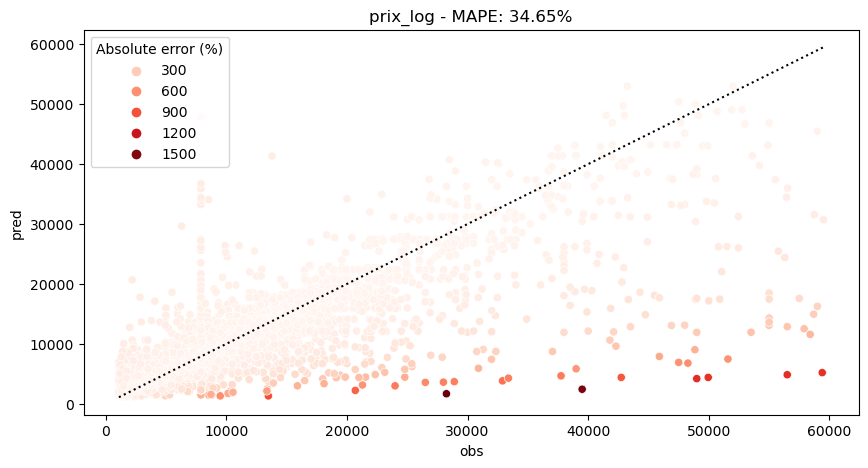

In [140]:
colors = sns.color_palette(palette="Set2", n_colors=2)

fig.suptitle(f"Predictions on test set", fontsize=12)

for target, color in zip(["prix_log"], colors):

    plot_predictions(
        y_true=preds[target]["y_true"],
        y_pred=preds[target]["y_pred"],
        color=color,
        title=target); 